In [1]:
import numpy as np
import h5py
import scipy
from scipy.signal import wiener, medfilt
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
from imblearn.over_sampling import SMOTE
from sklearn import svm
import os
import pickle
%matplotlib inline


In [3]:
#loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [2]:
ct_data, pet_data, label_data = [], [], []
num_data = 5
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    for ct_img, pet_img, label in zip(p_data['ct_data'].values(),
                                      p_data['pet_data'].values(),
                                      p_data['label_data'].values()):
        #print(np.shape(ct_img))
        #print(len(ct_img))
        ct_data += [np.array(ct_img)]
        pet_data += [np.array(pet_img)]
        label_data += [np.array(label)]
        num_data = num_data - 1
        if num_data == 0:
            break

# Dividing Data into 16x16x16 cubes

In [3]:
ct_cubes, pet_cubes,lab_cubes = [], [], []
tile_size=16
stride=3
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for z in range(0,  ct_img.shape[2], tile_size):
                for i_k in range(0, tile_size, stride):
                    for j_k in range(0, tile_size, stride):
                        for z_k in range(0,tile_size,stride):
                            ct_cubes += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            pet_cubes += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]]
                            lab_cubes += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size),z+z_k:(z+z_k+tile_size)]] 


In [4]:
# The following functions take a cube and an axis and return a projection of the tile along the axis
from sklearn.preprocessing import normalize

def reduceCTCube(cube,axis):
    return np.sum(cube,axis)
    
def reducePETCube(cube,axis):
    #if(np.sqrt(np.max(cube,axis)==nan)):
        #print(mk,axis)
    cube_array=np.sqrt(np.max(cube,axis))
    where_are_NaNs = np.isnan(cube_array)
    #print([where_are_NaNs])
    cube_array[where_are_NaNs] = 0.001386386961242742
    #return np.sqrt(np.max(cube,axis))
    #if np.any(np.isnan(cube_array)):
        #print('sad')
    return cube_array
    
def reduceLabelCube(cube):
    # write here, returns a single value, not a list/array    
    return(np.mean(cube))

# Projecting the cube along the 3 axes to get 3\*16\*16=768 features

In [ ]:
 data_tiles, data_labels = [], []

n_ct_cubes = [c_tile for c_tile in ct_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_pet_cubes = [c_tile for c_tile in pet_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]
n_lab_cubes = [c_tile for c_tile in lab_cubes if c_tile.shape == (tile_size,tile_size,tile_size)]

#ct_cube_final, pet_cube_final, lab_cube_final = zip(*[(c_cube, p_cube, l_cube) 
      #for c_cube, p_cube, l_cube in zip(n_ct_cubes, n_pet_cubes, n_lab_cubes)
     #if np.mean(c_cube) > -1001 and np.mean(p_cube) > .0002])
#print('%d tiles removed' % (len(n_ct_cubes)-len(ct_cube_final)))

#print(len(pet_cube_final))

#for ct_cube, pet_cube, lab_cube in zip(ct_cube_final, pet_cube_final,lab_cube_final):
#mk=0
for ct_cube, pet_cube, lab_cube in zip(n_ct_cubes, n_pet_cubes,n_lab_cubes):
    data_tile = []
    for axis in range(3):
        a=reducePETCube(pet_cube, axis).flatten()
        data_tile = np.concatenate([data_tile, a])
                
    #mk=mk+1
    #print()
    data_tiles += [data_tile]
    data_labels += [reduceLabelCube(lab_cube)]
print(len(n_ct_cubes))    
print(np.count_nonzero(np.array(data_labels))/float(len(data_labels)))

C:\Users\Himanshu\Miniconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


# Dividing into trainig and test set

In [8]:
lab_class = [c_score > 0 for c_score in data_labels]
from sklearn.model_selection import train_test_split
train_tiles, test_tile, train_score, test_score = train_test_split(data_tiles, data_labels, 
                                                                   train_size = 0.8, stratify = lab_class, random_state = 1234)
#print(type(train_score))
#print(np.array(train_tiles).shape)

# Principle Component Analysis

In [9]:
def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    pca.fit(train_tiles)
    return pca

pca = doPCA()
print(pca.explained_variance_ratio_)
#first_pc = pca.components_[0]

pca_train_tiles = pca.transform(train_tiles)
pca_test_tiles = pca.transform(test_tile)

[ 0.79326433  0.05884115  0.03759604  0.01881603  0.01553948]


# Applying SMOTE to generate more positive examples

In [10]:
sm = SMOTE(kind='svm')
train_tiles_resampled, train_score_resampled = sm.fit_sample(np.array(pca_train_tiles), (np.array(train_score)>0).astype(int) )

In [11]:
#print(np.count_nonzero(np.array(train_score_resampled))/float(train_score_resampled.shape[0]))

# Applying SVM (Classifier)

In [12]:
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(train_tiles_resampled, np.array(train_score_resampled))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
test_p =clf.predict(pca_test_tiles)

# Perfomance on test set- Confusion Matrix

In [14]:
#test_predictions = []
#test_p = clf.predict(test_t)
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(test_score)>0, test_p)

array([[333,  35],
       [  4,   3]])

# Performance on test set- Graph

(-0.1, 1.1)

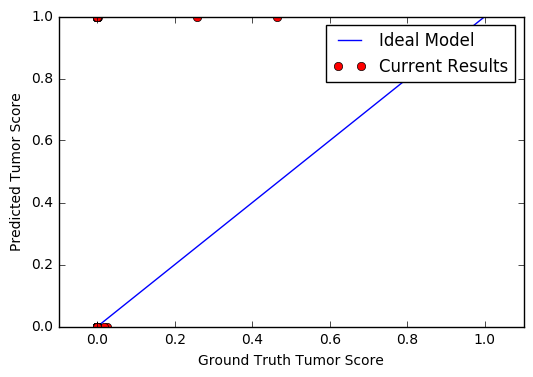

In [17]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Ideal Model')
ax1.plot(test_score, test_p, 'ro', label = 'Current Results')
ax1.set_xlabel('Ground Truth Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)